In [1]:
# Import libraries for loading data, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import join

# Load Review Data

Load and filter data for analysis/visualization

In [2]:
# This gets you to your code directory
path = Path.cwd()
# This gets you to your project directory
ROOT_DIR = path.parent.absolute()
# Root for data directory
r_fp = join(ROOT_DIR, 'data', 'processed')

In [3]:
# Read review data
open_df = pd.read_csv(join(r_fp, 'articles_reviewed.csv'),
                      encoding='latin1')
# Drop articles with dropped == 1
open_df = open_df[open_df['dropped'] != 1]

In [4]:
# Read journal data and get 2022 JIF
journals = pd.read_csv(join(r_fp, 'journals_to_search.csv'))

# Make Journal name column in journals all upper case
# Get dict of this to 2022 JIF column
jif_dict = dict(zip(journals['Journal name'].str.upper(),
                    journals['2022 JIF']))

# After doing grouping and pivots for summary stats and plotting,
# we will use this dict to get JIF linked 

# Summarize Review

## Get summary statistics overall and by journal

In [5]:
# Overall data and code
print(open_df['data_open'].value_counts())
print()
print(open_df['code_open'].value_counts())
print()

print(open_df['data_open'].value_counts()/len(open_df))
print()
print(open_df['code_open'].value_counts()/len(open_df))
print()


# Check that there are no missing records
check = (open_df['data_open'].value_counts().sum() ==
         open_df['code_open'].value_counts().sum())

if check:
    print('Continue :)')
else:
    print('STOP!!!')
    

data_open
Closed              166
Partially Closed     77
Open                 15
Name: count, dtype: int64

code_open
Closed              192
Partially Closed     53
Open                 13
Name: count, dtype: int64

data_open
Closed              0.643411
Partially Closed    0.298450
Open                0.058140
Name: count, dtype: float64

code_open
Closed              0.744186
Partially Closed    0.205426
Open                0.050388
Name: count, dtype: float64

Continue :)


In [6]:
# Get a dataframe of data openness by journal
# Can use any column as the values argument since
# the data is one record per row
data_byj = open_df.pivot_table(columns=['data_open'], index=['journal'], 
                               values=['authors'], aggfunc='count').fillna(0)

# Get a dataframe of code openness by journal
code_byj = open_df.pivot_table(columns=['code_open'], index=['journal'],
                               values=['authors'], aggfunc='count').fillna(0)

# Rename columns and then concat the dfs
data_byj.columns = ['closed_d', 'open_d', 'partial_d']
code_byj.columns = ['closed_c', 'open_c', 'partial_c']
open_byj = pd.concat([data_byj, code_byj], axis=1).reset_index()

# Map in the 2022 JIF column
open_byj['jif'] = open_byj['journal'].map(jif_dict)

# Get number of articles reviewed per journal
jsize_df = open_df['journal'].value_counts().reset_index()
jcount_dict = dict(zip(jsize_df['journal'], jsize_df['count']))
# Map these numbers into open_byj
open_byj['n_rev'] = open_byj['journal'].map(jcount_dict)

In [7]:
# Get proportions for each category based on n_rev
# and print wiht journal in the index
j_prop = ((open_byj.iloc[:, 1:7].T)/open_byj.iloc[:,-1]).T
j_prop_df = j_prop.set_index(open_byj['journal']).reset_index()
# Map in the jif to the prop df
j_prop_df['jif'] = j_prop_df['journal'].map(jif_dict)
print('Proportions\n')
print(j_prop.set_index(open_byj['journal']))

Proportions

                                     closed_d    open_d  partial_d  closed_c  \
journal                                                                        
COMMUNICATIONS EARTH & ENVIRONMENT   0.448276  0.034483   0.517241  0.379310   
EARTHS FUTURE                        0.703704  0.111111   0.185185  0.777778   
ENVIRONMENTAL RESEARCH               1.000000  0.000000   0.000000  1.000000   
ENVIRONMENTAL SCIENCE & TECHNOLOGY   0.740741  0.000000   0.259259  0.925926   
GLOBAL CHANGE BIOLOGY                0.464286  0.107143   0.428571  0.821429   
JOURNAL OF ENVIRONMENTAL MANAGEMENT  1.000000  0.000000   0.000000  1.000000   
LANCET PLANETARY HEALTH              0.736842  0.105263   0.157895  0.894737   
NATURE CLIMATE CHANGE                0.241379  0.172414   0.586207  0.206897   
ONE EARTH                            0.133333  0.066667   0.800000  0.666667   
REMOTE SENSING OF ENVIRONMENT        0.800000  0.000000   0.200000  0.840000   
WATER RESEARCH             

## Plot the journal-level results

In [12]:
# Prepare data
# We want the x-axis to be an abbrevation/acronym for the journal
# and the 2022 JIF in parantheses
# We sort by JIF from left to right
temp = j_prop_df.sort_values('jif', ascending=False)
temp['j_acr'] = temp['journal'].str.split(' ').apply(lambda x: ''.join([i[0][0] for i in x]))
temp['acr_jif'] = temp['j_acr'] + '\n(' + temp['jif'].astype(str) + ')'

# One dataframe for data
data_df = temp.set_index('acr_jif')[['closed_d', 'partial_d', 'open_d']]
# The other for code
code_df = temp.set_index('acr_jif')[['closed_c', 'partial_c', 'open_c']]

# Rename columns 
# First, cut off the _d and _c
data_df.columns = [x.split('_')[0] for x in data_df.columns]
code_df.columns = [x.split('_')[0] for x in code_df.columns]

# Then use the rename map below
rename_map = {'closed': 'Closed',
              'partial': 'Barriers to openness',
              'open': 'Open as defined by stated ideals'}
data_df = data_df.rename(columns=rename_map)
code_df = code_df.rename(columns=rename_map)

# Get rounded percentages
data_df = round(data_df*100, 2)
code_df = round(code_df*100, 2)

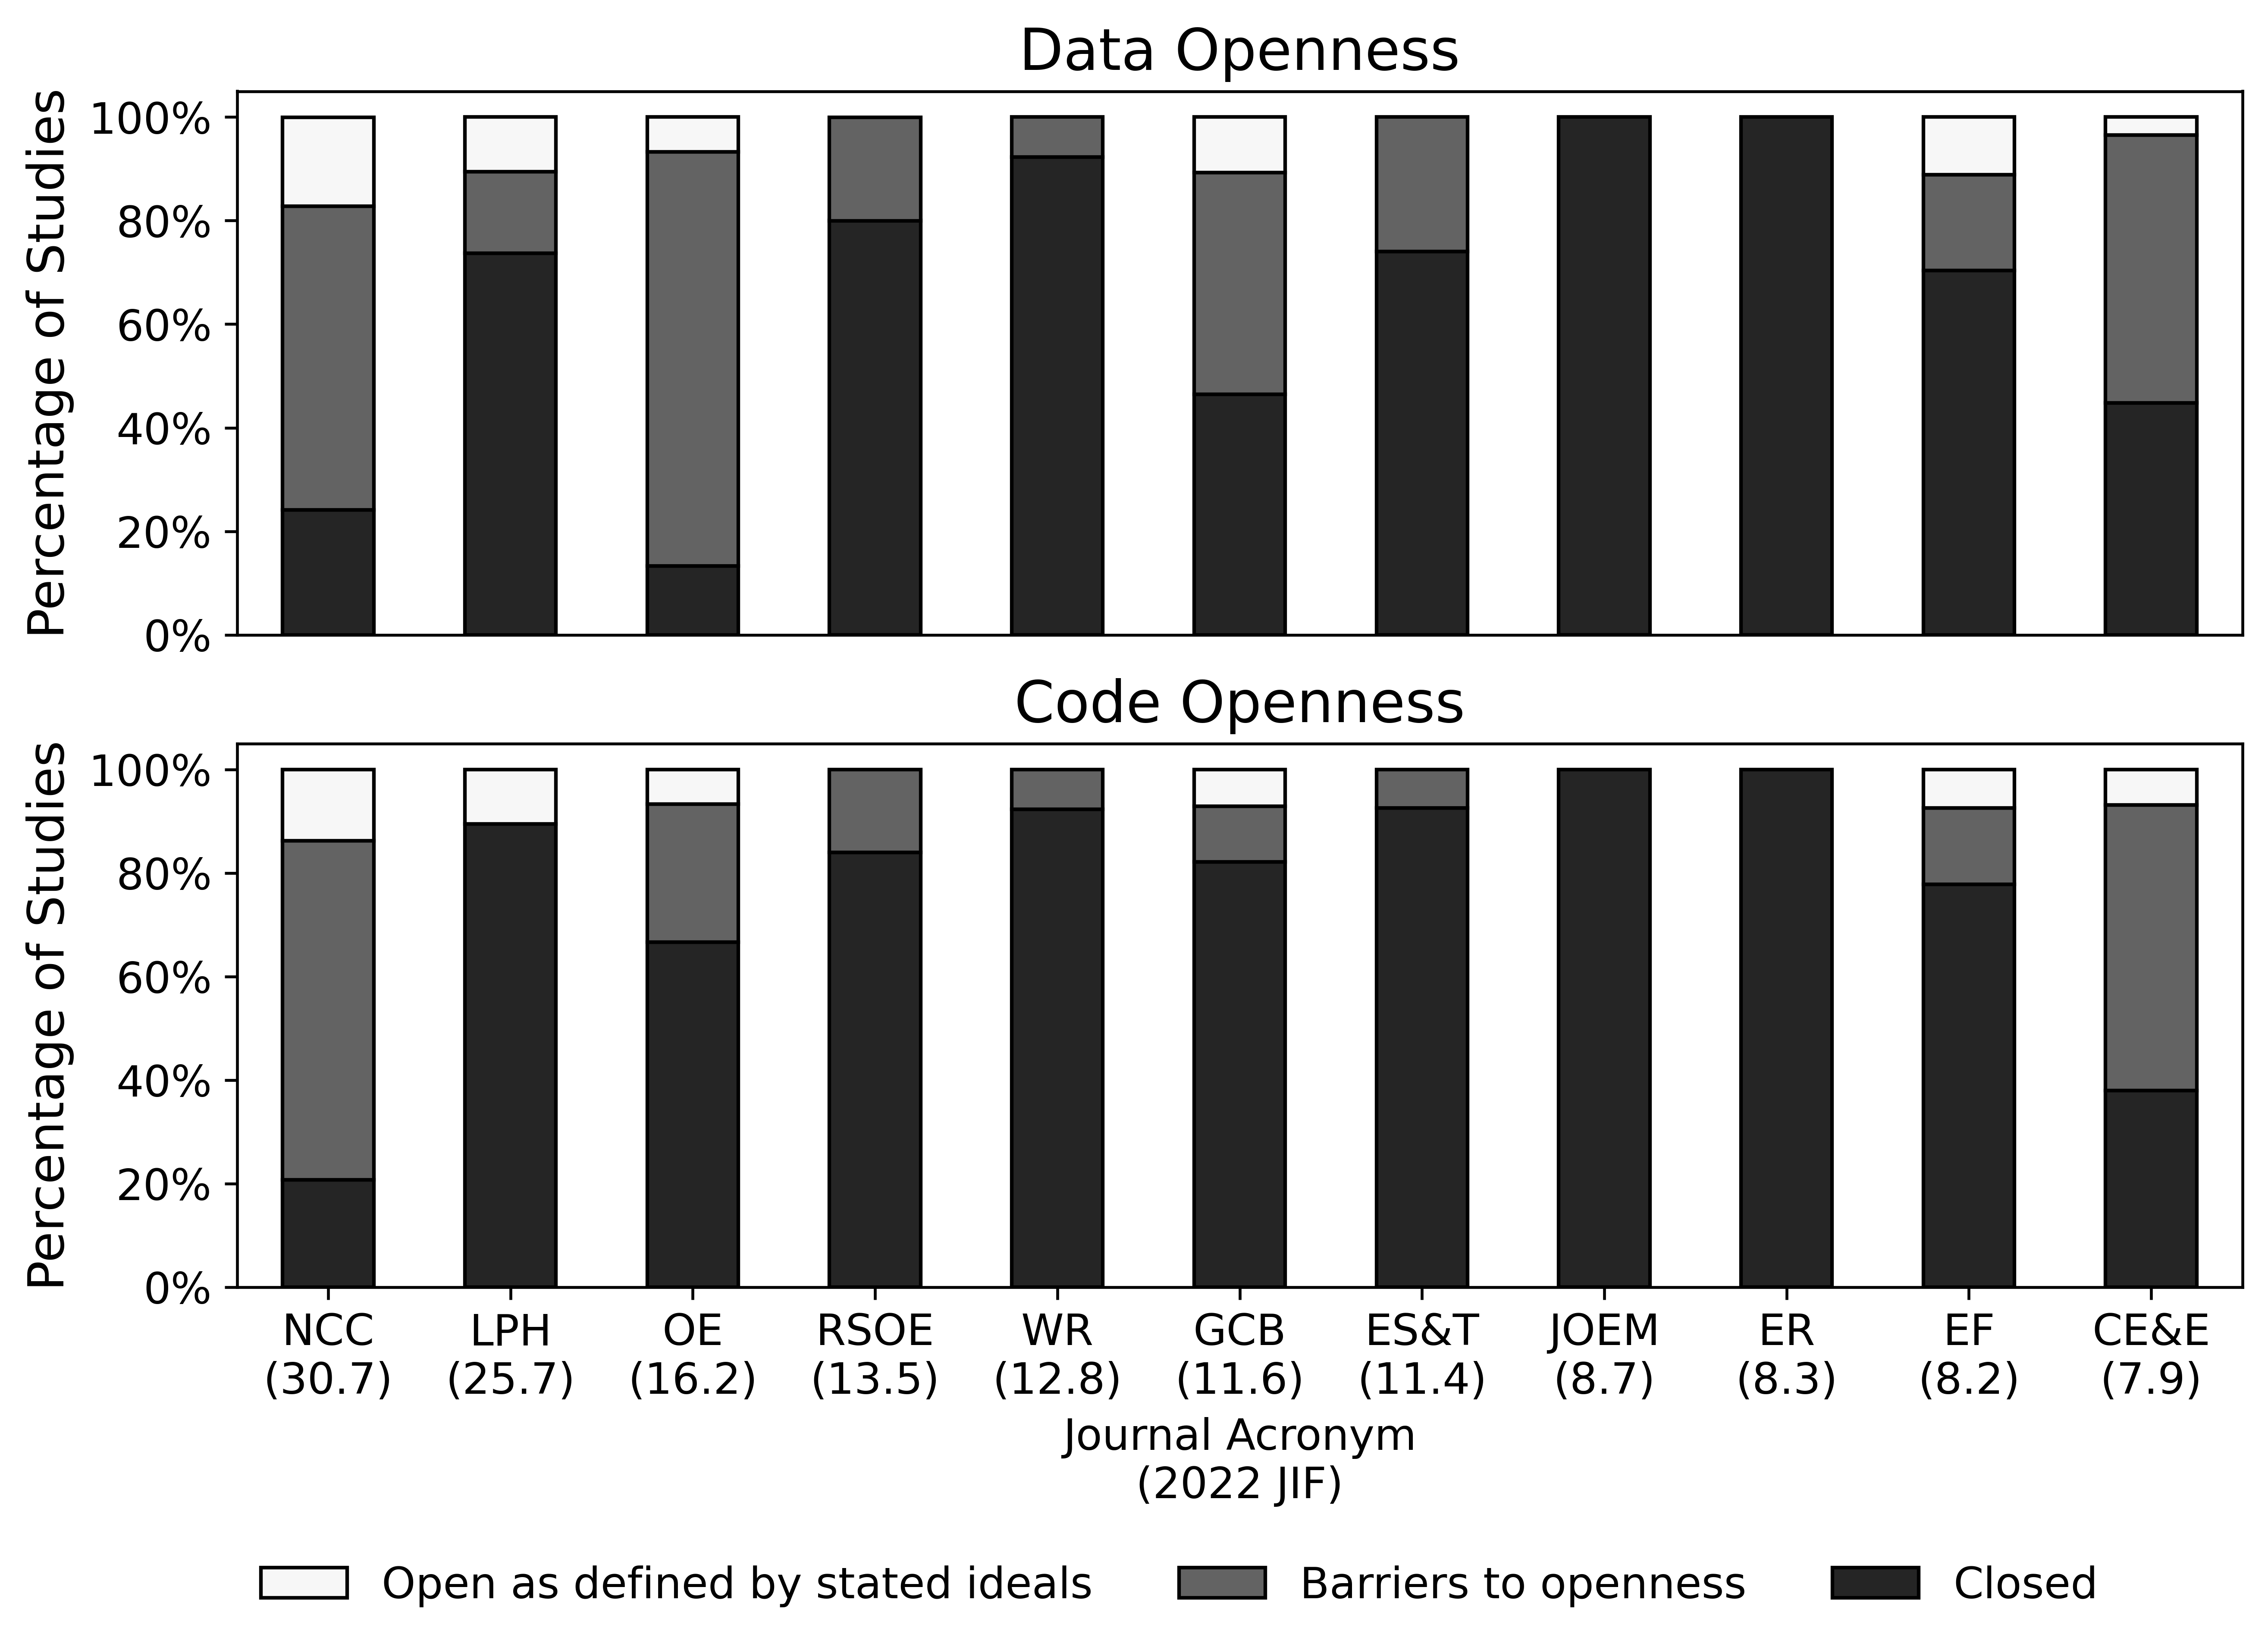

In [35]:
# Plot on a 1 by 2 axis
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, 
                       sharex=True, dpi=600)

data_df.plot(ax=ax[0], kind='bar', stacked=True,
             color=['#252525', '#636363', '#f7f7f7'],
             edgecolor='black',
             legend=False)

code_df.plot(ax=ax[1], kind='bar', stacked=True,
             color=['#252525', '#636363', '#f7f7f7'],
             edgecolor='black',
             legend=False)


ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='x', which='both',
                  bottom=False)

ax[0].set_title('Data Openness', size=16)
ax[1].set_title('Code Openness', size=16)

ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

handles, labels = ax[1].get_legend_handles_labels()

ax[1].legend(reversed(handles),
             reversed(labels),
             loc='center',
             bbox_to_anchor=(0.47, -0.55),
             fancybox=False,
             shadow=False,
             frameon=False,
             fontsize='large',
             ncol=3)

ax[1].set_xlabel('Journal Acronym\n(2022 JIF)', size=12)
ax[1].set_xticks(ax[1].get_xticks(),
                 ax[1].get_xticklabels(),
                 rotation=0,
                 ha='center')

fig.savefig(join(ROOT_DIR, 'fig', 'fig1.png'),
            dpi=600,
            bbox_inches='tight') 


## Summarize key features of not open papers

In [39]:
# Let's get one df for not open data
closed_data = open_df[open_df['data_open'] != 'Open']

# Let's get another df for not open code
closed_code = open_df[open_df['code_open'] != 'Open']

In [43]:
# With these datasets, we want to better understand things like
# What reasons do we get for not having openness?
# What is shared, if at all?
# What issues are there with what is shared?

In [57]:
# First, we inspect the reasons that some data was not shared
# Most often, no reason is provided
# Next most common, studies say they will share upon request or 
# reasonable request
# There are a few rare reasons. Privacy is cited twice, 
# authors say they don't have permission twice,
# one group says they have confidentiality concerns, another says
# they are bound to a confidentialy agreement, and another
# says they can share after a proposal or data use agreement
closed_data['data_reasons'].str.split(';').explode().str.strip().value_counts()

data_reasons
Nothing                      215
Upon Request                  15
Reasonable Request            11
Privacy                        2
No Permission                  2
Proposal Required              2
Data use agreements            1
Confidentiality Concerns       1
Confidentiality Agreement      1
Name: count, dtype: int64

In [62]:
# Next, we inspect what data is included when a study shares some
# but has barriers to openness
# Most often, raw data is shared, followed by results (usually model output,
# often not clear if it is results from all analyses conducted since 
# authors often say ambiguous things in their data statements about
# what exactly they're sharing and the repositories don't always offer
# more guidance)
# Source Data -- for figures and tables -- is rarely provided
# Very infrequently, All data is provided, it just is in a repo
# that does not guarantee permanent & persistent access
barrier_data = closed_data[closed_data['data_open'] != 'Closed']
barrier_data['data_included'].str.split(';').explode().str.strip().value_counts()

data_included
Raw                   45
Results               29
Source Data            9
All                    2
Figures                2
Processed              2
Sample                 2
Aggregated Results     1
Model Inputs           1
Summary Statistics     1
Source                 1
Name: count, dtype: int64

In [63]:
# It's also helpful to look at the above results in terms
# of the combos of data available 
# We see that sometimes there are studies that share more than just 
# raw data
barrier_data['data_included'].value_counts()

data_included
Raw                          31
Results                      19
Raw; Results                  6
Source Data                   4
Results; Source Data          2
Sample                        2
Raw; Processed                2
Raw; Figures                  2
All                           2
Source; Raw                   1
Raw; Summary Statistics       1
Aggregated Results            1
Model Inputs                  1
Raw; Source Data              1
Source Data; Results          1
Raw; Results; Source Data     1
Name: count, dtype: int64

In [65]:
# So, what are the issues with how data is being shared?
# Most often, a study is just posting URLs -- sometimes broken even a
# few months after being published -- which is not accessible and machine
# readable
closed_data['data_limitation_other'].str.split(';').explode().str.strip().value_counts()

data_limitation_other
URLs                  67
Need Account           1
Conditional Access     1
Name: count, dtype: int64

In [66]:
# When we just look at the studies which do share some data in a repo, 
# we see that even these have limitations in how some data is shared
# specifically, many of these studies post data sources as URLs which
# limits the ability of other researchers to attempt to reproduce 
# the present study. To reiterate, these are studies which
# do make some of their data open
# Some repos are not accessible in that you need an account or
# permission to access the data
barrier_data['data_limitation_other'].str.split(';').explode().str.strip().value_counts()

data_limitation_other
URLs                  29
Need Account           1
Conditional Access     1
Name: count, dtype: int64

In [69]:
# For the studies which are making their data open but also posting URLs,
# what kind of data are they sharing? 
# Most often, they share a subset of their raw data as open
# Other times, they also share results, data for figures (which is source
# data - but we try to code what the authors say in their statement), and
# other types of data. But it's very rare that there are multiple
# sources shared. 
barrier_sub = barrier_data[barrier_data['data_limitation_other'] == 'URLs']
barrier_sub['data_included'].value_counts()

data_included
Raw                          11
Raw; Results                  4
Raw; Figures                  2
Results; Source Data          2
Source Data                   2
Raw; Summary Statistics       1
Raw; Processed                1
Source; Raw                   1
Raw; Source Data              1
Results                       1
Source Data; Results          1
Raw; Results; Source Data     1
Name: count, dtype: int64

In [59]:
# We see similar reasons for code as for data
closed_code['code_reasons'].str.split(';').explode().str.strip().value_counts()

code_reasons
Nothing               213
Upon Request           12
Reasonable Request      8
License agreement       1
Proprietary             1
ArcMap                  1
No Permission           1
Name: count, dtype: int64

In [70]:
# We see that in general only a subset of code is shared
# there are a few notable examples where code for multiple parts of
# the inquiry are included -- but not all, or all just not in the
# right type of repo to be classified as open. This indicates
# that there is some room for stronger guidance to push authors in
# the right direction for following open research practices. But
# the predominance of no code at all shows there is a lot of work
# to be done
closed_code['code_included'].value_counts()

code_included
Nothing                                 191
Model                                    11
Models                                    8
All                                       5
Analysis                                  5
Results                                   4
Processing                                2
Generate Results                          2
Analysis; Figures                         2
Results; Figures                          2
Model; Figures                            2
Generate Results; Figures                 1
Excel Template                            1
Models; Results                           1
Download; Process; Analysis; Figures      1
Processing; Generate Results              1
Processing; Figures                       1
Processing; Results                       1
Sample                                    1
Models; Analysis                          1
Figures                                   1
Name: count, dtype: int64